# Chapter 1: Image-Deconvolution 1


## Problem motivation

<img align="center" src="images/BlurCollage.png"></img>

Real world images we capture are blurry and noisy. 

## Problem formulation
Given a blurry-image ($b$) and a point spread function (PSF) $h$ estimate the clean latent image $i$. Additive noise $n$ is present while measuring the image.    
$$b=i \ast h+n$$


In [30]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import image as image_utils

img = cv2.imread("images/input.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img.astype(np.float32)/255
size = 15

kernel_motion_blur = np.zeros((size,size))
kernel_motion_blur[int((size-1)/2), :] = np.ones(size)
kernel_motion_blur = kernel_motion_blur/size

# fliter output 
output = cv2.filter2D(img, -1, kernel_motion_blur)
# Add random noise 
row,col,ch= output.shape
mean = 0
var = 0.001
sigma = var**0.5
gauss = np.random.normal(mean,sigma,(row,col,ch))
gauss = gauss.reshape(row,col,ch)
outputNoisy = output + gauss

Text(0.5,1,'Blurry Noisy Output')

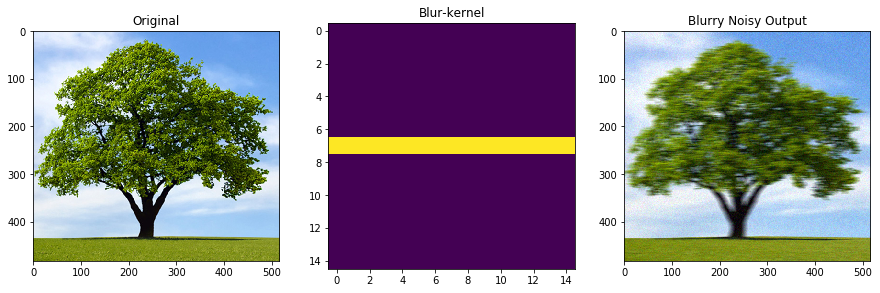

In [31]:
plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(image_utils.convert_float32_to_uint8(img))
plt.title('Original')
plt.subplot(132)
plt.imshow(kernel_motion_blur)
plt.title('Blur-kernel')
plt.subplot(133)
plt.imshow(image_utils.convert_float32_to_uint8(outputNoisy))
plt.title('Blurry Noisy Output')

## Optimization-based techniques 

- Wiener based deconvolution 
- Richardson-Lucy deconvolution
- Iterative deconvolution techniques


## Wiener-filter based deconvolution

- A block diagram for the blurry image is given as   
<img align="center" src="images/inverseFilterNoise.png" width="250"></img>
Fourier-domain: 
$$B(\omega)=I(\omega)H(\omega)+N(\omega)$$
$$\implies I(\omega)=\frac{B(\omega)-N(\omega)}{H(\omega)}$$
- Noise can be amplified in the regions where $H(\omega)$ has small values. 
- A Wiener filter is the best linear filter that can be used on the blurry image to deblur it. 
<img align="center" src="images/wienerFilterBlockDiagram.png" width="250"></img>

## Wiener-filter based deconvolution

-The Wiener-filtering: best linear filter applied on $b[k]$ to account for noise characteristics
-Let the filter in the frequency domain be given by $G(\omega)$. 
-Let us assume that we know the autocorrelation of the signal $E[|X(\omega)|^2]=S(\omega)$ 
-The filter is designed to minimize
$$\epsilon(\omega)=E[|\hat{I}(\omega)-I(\omega)|^2]$$
$$=E[|I(\omega)-G(\omega)B(\omega)|^2]$$
$$=E[|I(\omega)-G(\omega)[H(\omega)I(\omega)+N(\omega)]|^2]$$
$$=E[|I(\omega)(1-G(\omega)H(\omega))-G(\omega)N(\omega)|^2]$$
$$=E[[I(\omega)(1-G(\omega)H(\omega))-G(\omega)N(\omega)]^\ast [I(\omega)(1-G(\omega)H(\omega))-G(\omega)N(\omega)]]$$
$$=E[|I(\omega)|^2|1-G(\omega)H(\omega)|^2+|G(\omega)N(\omega)|^2-I(\omega)G^\ast(\omega)N^\ast(\omega)(1-G(\omega)H(\omega))-G^\ast(\omega)N^\ast(\omega)I(\omega)(1-G(\omega)H(\omega))]$$
-The last two terms are 0 because $E[I^\ast(\omega)N(\omega)]=E[I(\omega)N^\ast\omega]=0$. 

## Wiener-filter based deconvolution

$$\epsilon(\omega)=S(\omega)|1-G(\omega)H(\omega)|^2+|G(\omega)N(\omega)|^2$$
$$=S(\omega)[1-G(\omega)H(\omega)][1-G(\omega)H(\omega)]^\ast+[G(\omega)G^\ast(\omega)|N(\omega)|^2]$$
- Taking the Wirtinger derivative of this expression results and equating to zero
$$S(\omega)(1-G(\omega)H(\omega))^\ast [-H(\omega)]+G^\ast(\omega)|N(\omega)|^2=0$$
$$ \implies G^\ast (\omega)=\frac{S(\omega)H(\omega)}{E[|N(\omega)|^2]+|H(\omega)|^2S(\omega)}$$
$$ \implies G (\omega)=\frac{S(\omega)H^\ast(\omega)}{E[|N(\omega)|^2]+|H(\omega)|^2S(\omega)}$$
- Denoting $SNR=\frac{E[|X(\omega)|^2]}{E[|N(\omega)|^2]}=\frac{S(\omega)}{E[|N(\omega)|^2}$
$$ \implies G (\omega)=\frac{H^\ast(\omega)}{SNR+|H(\omega)|^2}$$

In [105]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import image as image_utils
from scipy import signal

img = cv2.imread("images/input.png")
img = img.astype(np.float32)/255
img = np.mean(img,2)
size = 10

kernel_motion_blur = np.zeros((size,size))
kernel_motion_blur[int((size-1)/2), :] = 1
kernel_motion_blur = kernel_motion_blur/size

# fliter output 
output = cv2.filter2D(img, -1, kernel_motion_blur)

# Add random noise 
row,col= output.shape
mean = 0
var = 0.001
sigma = var**0.5
gauss = np.random.normal(mean,sigma,(row,col))
gauss = gauss.reshape(row,col)
output = output + gauss

outputFFT = np.fft.fft2(output)
filterFFT = np.fft.fft2(kernel_motion_blur,s=(outputFFT.shape))
epsilon   = 1e-1 # Add some epsilon to make sure we are not dividing by zero 

# inverse-filter estimate
inverseFilterFFT = outputFFT/(filterFFT+epsilon)
inverseFilterEstimate = np.real(np.fft.ifft2(inverseFilterFFT))

# wiener-filter estimate
SNR = 1
wienerFilterFFT = np.conj(filterFFT)/(np.square(np.abs(filterFFT))+SNR)
wienerFilterEstimate = np.real(np.fft.ifft2(wienerFilterFFT*outputFFT))

Text(0.5,1,'Wiener filter estimate')

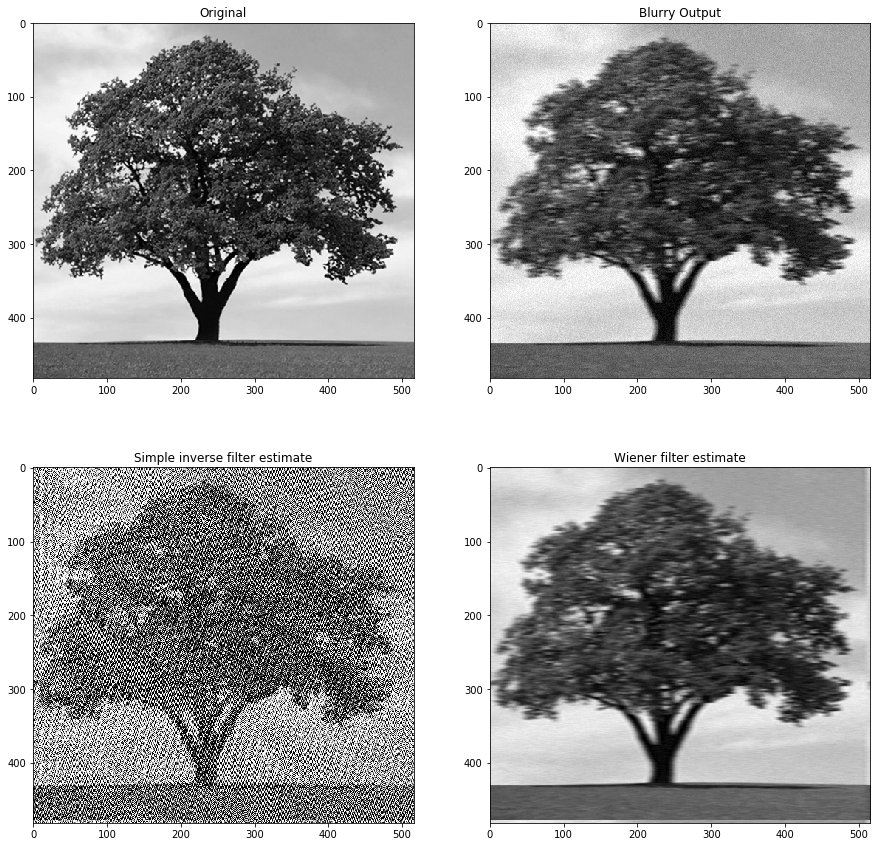

In [112]:
plt.figure(figsize=(15,15))
plt.subplot(221)
plt.imshow(image_utils.convert_float32_to_uint8(img), cmap='gray')
plt.title('Original')
plt.subplot(222)
plt.imshow(image_utils.convert_float32_to_uint8(output), cmap='gray')
plt.title('Blurry Output')
plt.subplot(223)
plt.imshow(image_utils.convert_float32_to_uint8(inverseFilterEstimate), cmap='gray')
plt.title('Simple inverse filter estimate')
plt.subplot(224)
plt.imshow(image_utils.convert_float32_to_uint8(wienerFilterEstimate), cmap='gray')
plt.title('Wiener filter estimate')

## Richardson-Lucy deconvolution (RL)
- According to the earlier notation, the block diagram for the blurry image is given as   
<img align="center" src="images/inverseFilterNoise.png" width="250"></img>
- The degraded noise model is given as $b=h*i+n$ under poisson statistics for the noise. 
- The RL deconvolution algorithm is given as 
$$u^{t+1}=u^t\Big(h \ast \frac{b}{h\ast u^t}\Big)$$
- This iterative method is used until the algorithm converges.  

In [143]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import image as image_utils
from scipy.signal import convolve2d as conv2
from scipy import signal
from skimage import color, data, restoration

astro = color.rgb2gray(data.astronaut())
psf = np.ones((5, 5)) / 25
astro = conv2(img, psf, 'same')

# Add Noise to Image
astro_noisy = astro.copy()
astro_noisy += (np.random.poisson(lam=25, size=astro.shape) - 10) / 255.

# Restore Image using Richardson-Lucy algorithm
deconvolved_RL = restoration.richardson_lucy(astro_noisy, psf, iterations=30)

Text(0.5,1,'Richardson Lucy (RL) estimate')

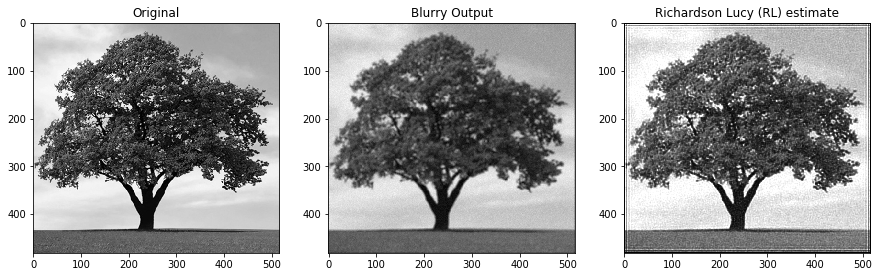

In [144]:
plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(img, cmap='gray')
plt.title('Original')
plt.subplot(132)
plt.imshow(astro_noisy, cmap='gray')
plt.title('Blurry Output')
plt.subplot(133)
plt.imshow(deconvolved_RL, cmap='gray')
plt.title('Richardson Lucy (RL) estimate')

In [ ]:
## Iterative deconvolution techniques 


## Deep-learning based techniques 

## Comparison in performance  